In [1]:
import pandas as pd
import numpy as np

'''
Reduced features
'''
df_feats = pd.read_csv('reduced_data.csv')
df_labels = pd.read_csv('disorders.csv')['Depressed']

df_red = pd.concat([df_feats, df_labels], axis=1)
df_red_depr = df_red.loc[df_red['Depressed'] == 1].drop(['Depressed'], axis=1, inplace=False) # depressed 
df_red_not_depr = df_red.loc[df_red['Depressed'] == 0].drop(['Depressed'], axis=1, inplace=False) # not depressed 

# Get reduced features
red_depr = df_red_depr.get_values()
red_not_depr = df_red_not_depr.get_values()

In [2]:
'''
Original features
'''
df_patient = pd.read_csv('patient_info.csv')
df_disorders = pd.read_csv('disorders.csv')
df_questionnaire = pd.read_csv('questionnaire.csv')
df_base_concen = pd.read_csv('base_concen.csv')

df_patient = df_patient[['Age', 'Gender_id', 'race_id', 'location_id']]
df_disorders.drop(['Patient_ID', 'ADHD_Type'], axis=1, inplace=True)
df_questionnaire.drop(['Patient_ID', 'BSC_Respondent', 'GSC_Respondent', 'LDS_Respondent'], axis=1, inplace=True)
df_base_concen.drop(['Patient_ID', 'Baseline_header_id', 'Concentration_header_id'], axis=1, inplace=True)

df = pd.concat([df_patient, df_disorders, df_questionnaire, df_base_concen], axis=1)

df_depr = df.loc[df['Depressed'] == 1].drop(['Depressed'], axis=1, inplace=False) # depressed 
df_not_depr = df.loc[df['Depressed'] == 0].drop(['Depressed'], axis=1, inplace=False) # not depressed 

# Get original features
depr = df_depr.get_values()
not_depr = df_not_depr.get_values()

## Step 1: State assumptions

- We assume that depressed features are sampled according to: X<sub>i</sub> ∼<sup>iid</sup> F<sub>D</sub>, and non-depressed features are sampled according to: X<sub>i</sub> ∼<sup>iid</sup> F<sub>ND</sub>, which is both an independent and identical assumption.

## Step 2: Check assumptions

For independent features, check that off diagonal covariance is approximately 0.


For identical features, check the optimal number of clusters and see if that is 1.

### Independent Features Assumption

First let's try and determine if the matrix of reduced depressed people is independent

In [99]:
import numpy as np

# We don't want to ensure reproducibility, we want the sampling to be random everytime, this is because only then
# will iterative coverage of the rows of the large matrix be max

# Before we perform any identical-ness determination let's have a look at the shape of the matix
print "Shape of reduced features: " + str(red_depr.shape)

# variable to hold dependent count
dep_count = 0

for loop in range(0,100):

    # The number of entries far outnumber the number of reduced features. This almost guarantees linear dependence
    # To combat the let us random sample 27 values
    randrows = np.random.randint(1205,size=27)
    double_red_depr = red_depr[randrows]
    # print "Shape of double reduced features: " + str(double_red_depr.shape)

    # Now, let's calculate the rank of these matrix, if the rank is less than 27, then there are atleast 2 rows
    # that are dependent    
    rank = np.linalg.matrix_rank(double_red_depr)    
    if rank != 27:
        # print "Interdependent lines with matrank: " + str(rank)
        dep_count += 1
print "likely lower bound on dependent patients " + str(dep_count)

Shape of reduced features: (1205, 27)
likely lower bound on dependent patients 34


Over here our reasoning is this, the probability for 2 lines to be selected twice in 2 differrent sets of 27 from 1205 candidates is pretty low. But when repeated 100 times there is a high chance for double counting. Allowing for this double counting if the number is still less than 5% of the total number of patients we can safely say that our data is mostly independent

Following a similar technique for the set of reduced not depressed people

In [91]:
import numpy as np

# We don't want to ensure reproducibility, we want the sampling to be random everytime, this is because only then
# will iterative coverage of the rows of the large matrix be max

# Before we perform any identical-ness determination let's have a look at the shape of the matix
print "Shape of reduced features: " + str(red_not_depr.shape)

# variable to hold dependent count
dep_count = 0

for loop in range(0,100):

    # The number of entries far outnumber the number of reduced features. This almost guarantees linear dependence
    # To combat the let us random sample 27 values
    randrows = np.random.randint(1205,size=27)
    double_red_not_depr = red_not_depr[randrows]
    # print "Shape of double reduced features: " + str(double_red_depr.shape)

    # Now, let's calculate the rank of these matrix, if the rank is less than 27, then there are atleast 2 rows
    # that are dependent    
    rank = np.linalg.matrix_rank(double_red_not_depr)    
    if rank != 27:
        # print "Interdependent lines with matrank: " + str(rank)
        dep_count += 1
print "likely lower bound on dependent patients " + str(dep_count)

Shape of reduced features: (1591, 27)
likely lower bound on dependent patients 64


**Likely number of dependent entries for depressed set: **34/1205<br/>
**Likely number of dependent entries for not depressed set: **64/1591<br/>

Given this info, it might be safe to say that the data entries are by and large independent

###  Identical Features Assumption

- K-Means Clustering

In [4]:
from sklearn.cluster import KMeans
from mpl_toolkits.axes_grid1 import Grid

def cluster_feats(X, k, title, feat_names):
    # Visualize the clustering result
    fig = plt.figure()
    fig.suptitle(title, fontsize=14, fontweight='bold')
    fig.set_size_inches(10, 4)
    plt.subplots_adjust(top=0.85)

    grid = Grid(fig, rect=111, nrows_ncols=(1, 2),
                axes_pad=0.5, label_mode='L',
                )
    
    for i, ax in enumerate(grid):
        # Fit the data
        data = X[i].T
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(data)
        
        # Get cluster labels and centroids
        labels = kmeans.labels_
        centroids = kmeans.cluster_centers_
        
        # Plot clusters
        for j in range(k):
            # Extract observations within each cluster
            ds = data[np.where(labels==j)]
            
            # Plot the observations with symbol o
            ax.plot(ds[:,0], ds[:,1], 'o')
            
            # Plot the centroids with simbol x
            lines = ax.plot(centroids[j,0], centroids[j,1], 'x')
            plt.setp(lines, ms=8.0)
            plt.setp(lines, mew=2.0)
            
            ax.set_title(feat_names[i])

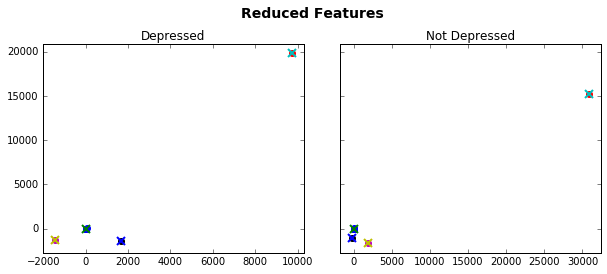

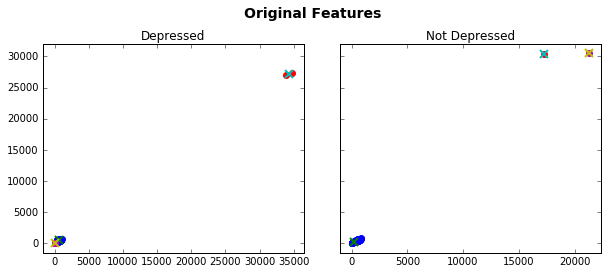

In [5]:
# Reduced Feature Clustering
red_feats = [red_depr, red_not_depr]
k = 4 # number of clusters
cluster_feats(red_feats, k, 'Reduced Features', ['Depressed', 'Not Depressed'])

# Original Feature Clustering
feats = [depr, not_depr]
k = 3 # number of clusters
cluster_feats(feats, k, 'Original Features', ['Depressed', 'Not Depressed'])

As shown in the figures above, the reduced depressed features and non-depressed features are not identical and both fall into four clusters, while the original depressed features fall into two groups and original non-depressed fall into three groups. Note that the reduced feature vector size is 27 and the original feature vector size is 737.

From above, we can conclude that our identical assumption is false.

- Gaussian Mixture Model for reduced features

In [5]:
import itertools
import matplotlib as mpl
from scipy import linalg
from sklearn.mixture import GMM

def plot_BIS(X, title):
    lowest_bic = np.infty
    bic = []
    n_components_range = range(1, 6)
    cv_types = ['spherical', 'tied', 'diag', 'full']
    for cv_type in cv_types:
        for n_components in n_components_range:
            # Fit a mixture of Gaussians with EM
            gmm = GMM(n_components=n_components, covariance_type=cv_type)
            gmm.fit(X)
            bic.append(gmm.bic(X))
            if bic[-1] < lowest_bic:
                lowest_bic = bic[-1]
                best_gmm = gmm

    bic = np.array(bic)
    color_iter = itertools.cycle(['k', 'r', 'g', 'b', 'c', 'm', 'y'])
    clf = best_gmm
    bars = []

    # Plot the BIC scores
    fig = plt.figure()
    fig.suptitle(title, fontsize=14)
    fig.set_size_inches(12, 4)
    plt.subplots_adjust(top=0.85)
    spl = plt.subplot(2, 1, 1)
    
    for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
        xpos = np.array(n_components_range) + .2 * (i - 2)
        bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                      (i + 1) * len(n_components_range)],
                            width=.2, color=color))
    plt.xticks(n_components_range)
    plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
    plt.title('BIC score per model')
    xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 +\
        .2 * np.floor(bic.argmin() / len(n_components_range))
    plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
    spl.set_xlabel('Number of components')
    spl.legend([b[0] for b in bars], cv_types, loc='best', prop={'size':10})

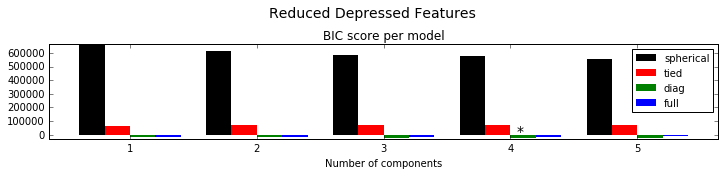

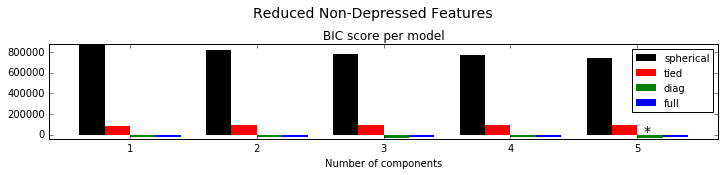

In [6]:
# Reduced Feature BIC
plot_BIS(red_depr, 'Reduced Depressed Features')
plot_BIS(red_not_depr, 'Reduced Non-Depressed Features')

Plot BIC (Bayesian information criterion) scores to decide which covariance type to use.

The model with the lowest negation of the BIC (highest BIC score above) is preferred, therefore spherical covariance type is selected. 

The definition on wiki leads to some confusion, the explanation can be found here: http://forum.hugin.com/index.php?topic=188.0.

#### Estimate clusters based on Greg's code.

In [7]:
def evaluate_clusters(X):
    i = np.linspace(1, 16, 16, dtype='int')
    bic = np.array(())

    for idx in i:
        print "Fitting and evaluating model with " + str(idx) + " clusters."
        gmm = GMM(n_components=idx, n_iter=1000, covariance_type='spherical')
        gmm.fit(X)
        bic = np.append(bic, gmm.bic(X))
    plt.figure(figsize=(7, 7))
    plt.plot(i, 1.0/bic)
    plt.title('BIC')
    plt.ylabel('score')
    plt.xlabel('number of clusters')
    plt.show()

    print bic

Fitting and evaluating model with 1 clusters.
Fitting and evaluating model with 2 clusters.
Fitting and evaluating model with 3 clusters.
Fitting and evaluating model with 4 clusters.
Fitting and evaluating model with 5 clusters.
Fitting and evaluating model with 6 clusters.
Fitting and evaluating model with 7 clusters.
Fitting and evaluating model with 8 clusters.
Fitting and evaluating model with 9 clusters.
Fitting and evaluating model with 10 clusters.
Fitting and evaluating model with 11 clusters.
Fitting and evaluating model with 12 clusters.
Fitting and evaluating model with 13 clusters.
Fitting and evaluating model with 14 clusters.
Fitting and evaluating model with 15 clusters.
Fitting and evaluating model with 16 clusters.


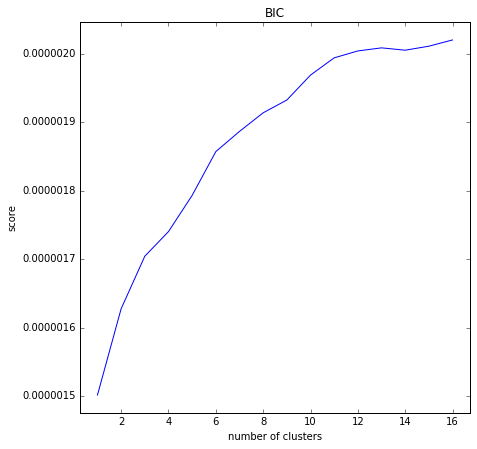

[ 665943.15874087  614389.54776157  586703.66916061  574587.88104984
  557631.5563946   538431.3846077   530006.23005936  522480.72251438
  517437.24934549  507864.89482388  501445.69473951  498927.04346143
  497804.31279593  498657.32781906  497202.57085904  494961.86574781]


In [8]:
evaluate_clusters(red_depr)

Fitting and evaluating model with 1 clusters.
Fitting and evaluating model with 2 clusters.
Fitting and evaluating model with 3 clusters.
Fitting and evaluating model with 4 clusters.
Fitting and evaluating model with 5 clusters.
Fitting and evaluating model with 6 clusters.
Fitting and evaluating model with 7 clusters.
Fitting and evaluating model with 8 clusters.
Fitting and evaluating model with 9 clusters.
Fitting and evaluating model with 10 clusters.
Fitting and evaluating model with 11 clusters.
Fitting and evaluating model with 12 clusters.
Fitting and evaluating model with 13 clusters.
Fitting and evaluating model with 14 clusters.
Fitting and evaluating model with 15 clusters.
Fitting and evaluating model with 16 clusters.


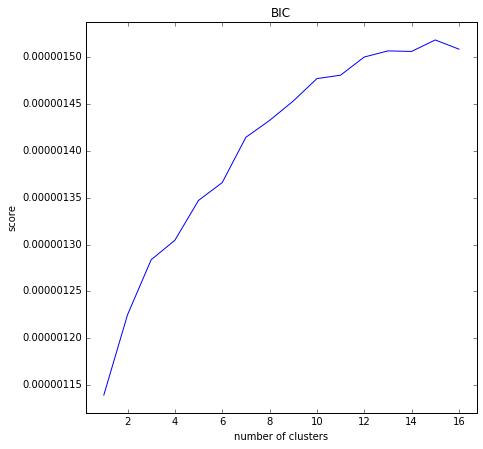

[ 877772.00392833  816371.00697729  778938.90339726  766543.86127108
  742307.29224827  731985.10462978  706929.49944019  698053.96058957
  688104.07379339  676935.05839146  675248.11718123  666522.64300224
  663630.18663853  663871.76477158  658516.32992991  662803.67343104]


In [9]:
evaluate_clusters(red_not_depr)

From the two figures above, we can see that the optimal numbers of clusters are 16 and 15 (at least), so our data may not have been sampled identically from one distribution. Here using Gaussian Mixture Model method we proved once again that the identical assumption is wrong.